# AB Testing Project
I have found an A/B dataset on kaggle.com, I am going to perform some hypothesis testing to compare the A/B tests and derive meaningful insights. 

**Purpose of this notebook:**
- Demonstrate my understanding of statistics in a business context. 
- Demonstrate my understanding of python in a data analysis context.

A dataset from kaggle.com has been used for this analysis. 

# Project 
## A/B Testing with Cookie Cats Dataset
### Problem Statement
Cookie Cats is an online mobile game. The dev team have decided that they want to see how changing a feature will affect their players. The feature being changed is the in-game level at which the player meets a gate. They want to understand the effects of a player encountering the gate later in the game (level 40) compared to earlier (level 30). The purpose of this analysis is to investigate whether there is a statistically significant effect of gate placement on player retention.

### Data
In order to make it clear what the data is showing, a description of each field / column has been added: 
- userid: The UUID of a given player. 
- version: This field refers to the A/B group, and contains either 'gate_30' or 'gate_40' as a value, the number referring to the level. 
- sum_gamerounds: This is the total number of rounds of Cookie Cats completed by a player during the first 14 days after install. 
- retention_1: Boolean value whether or not a player came back to play 1 day after installing. 
- retention_7: Boolean value whether or not a player came back to play 7 days after installing. 

**What relationships can be explored in this data to answer the problem statement? **
1. Effect of 'version' on 'sum_gamerounds'. 
2. Effect of 'version' on 'retention_1'. 
3. Effect of 'version' on 'retention_7'. 

### Hypotheses 
Measuring the effect of version on sum_gamerounds: 
- H0: Gate placement at level 40 does not have an effect on the number of rounds completed by a user vs placement at level 30. 
- H1: Gate placement at level 40 does have an effect on the number of rounds completed by a user vs placement at level 30. 

Measuring the effect of version on retention_1: 
- H0: Gate placement at level 40 does not have an effect on the 1 day retention of a user vs level 30. 
- H1: Gate placement at level 40 does have an effect on the 1 day retention of a user vs level 30. 

Measuring the effect of version on retention_2: 
- H0: Gate placement at level 40 does not have an effect on the 7 day retention of a user vs level 30. 
- H1: Gate placement at level 40 does have an effect on the 7 day retention of a user vs level 30. 

### Analysis

In [89]:
#Import libs
import pandas as pd 
import matplotlib.pyplot as plt
import math

#import data 
df = pd.read_csv('cookie_cats.csv')

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [90]:
df.shape

(90189, 5)

90,189 rows, 5 columns. 
Clean data, then split into A/B groups. 

In [91]:
#check for duplicated UIDs 
df.duplicated(subset=['userid']).any()

False

In [92]:
#Check for empty rows
df[df.isna().any(axis=1)]

,userid,version,sum_gamerounds,retention_1,retention_7


<AxesSubplot:>

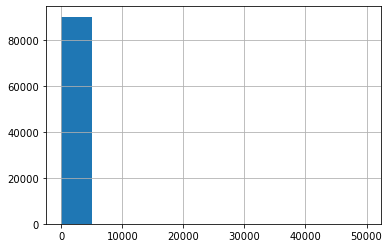

In [93]:
#check for weird entries
df['sum_gamerounds'].hist()

Something weird is going on.

In [95]:
df[df['sum_gamerounds'] > 5000]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


Clearly, that's some kind of anomaly. It shall be removed from the data.

In [84]:
#remove that weird row
df = df[df['sum_gamerounds'] != 49854]

<AxesSubplot:>

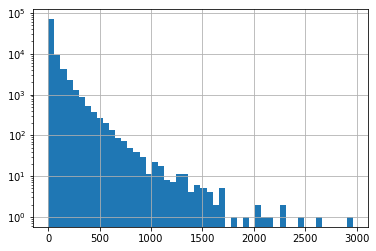

In [87]:
df['sum_gamerounds'].hist(bins=50, log=True)

Looking better. Some outliers, I will remove values with gamerounds higher than 1750, since these appear to be outlier events.

<AxesSubplot:>

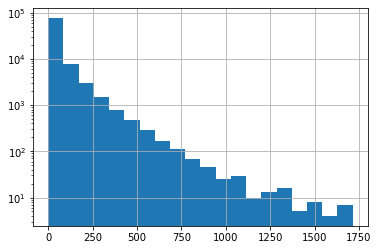

In [102]:
df = df[df['sum_gamerounds'] < 1750]
df['sum_gamerounds'].hist(bins=20, log=True)

In [103]:
#Split the datasets
a30 = df[df['version'] == 'gate_30']
b40 = df[df['version'] == 'gate_40']

a30.shape

(44694, 5)

In [104]:
b40.shape

(45483, 5)

### Addressing hypothesis 1
Does the A/B group have an effect on the number of rounds completed? Concretely, is there a statistically significant difference between the number of rounds completed between groups?

**Approach**

Population statistics are unknown (mean, sd), therefore a t-test will be used to compare sample means. 
It is unknown if A should be better than B, or vice versa, therefore a 2 tailed test will be used. 

A standard confidence level on 95% will be used. 

**Formula**

t statistic = (meanA - meanB) / root( (sdA^2 / n of A ) + (sdB^2 / n of B))

In [108]:
#mean 
aMu = a30['sum_gamerounds'].mean()
bMu = b40['sum_gamerounds'].mean()
#Sample size
aN = a30.shape[0]
bN = b40.shape[0]
#StDev
aSigma = a30['sum_gamerounds'].std()
bSigma = b40['sum_gamerounds'].std()
#test statistic
tstat = (aMu - bMu) / math.sqrt( ((aSigma**2) / aN) + ((bSigma**2) / bN) )
tstat

0.0979052827155265

In [109]:
#degrees of freedom
degfreedom = min(aN, bN) - 1
degfreedom

44693

Looking up a critical value for a 2-tailed t test with df = 44699, alpha = 0.05 => 1.960

The value of 0.09 is very well within the critical value and acceptance region. For this reason we can say with at least 95% confidence, (and actually more than this), that the A/B test had no effect on the number of levels completed.

**We have failed to reject the null hypothesis.**

In [110]:
#This result is unsurprising, since the difference between the means  of the two groups is actually very small: 
print(aMu - bMu)
#especially within the context of the standard deviations of each group.
print(aSigma, bSigma)

0.06502870738694355
99.07390338113002 100.38151656022475


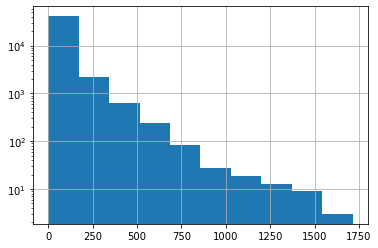

In [115]:
#Vizualizing the sampling means
a30['sum_gamerounds'].hist(log=True);

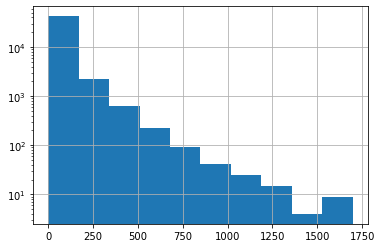

In [116]:
b40['sum_gamerounds'].hist(log=True);

The data are laregely the same.

### Addressing hypothesis 2
Does the A/B group have a statistically significant effect on 1 day user retention? 

**Approach**

It is unknown if A should be better than B, or vice versa, therefore a 2 Tailed test will be used. 

A standard confidence level of 95% will be used. 

**Formula**

Z statistic = (proportionA - proportionB) / root( ((proportionA * 1-proportionA) / (aN)) +  ((proportionB * 1-proportionB) / (bN)) )

In [117]:
#sample sizes
aN
bN
#Proportions 
propA = a30[ a30['retention_1'] == True].shape[0] / aN
propB = b40[ b40['retention_1'] == True].shape[0] / bN
#inverse proportions
propnotA = 1-propA
propnotB = 1-propB
#Z Statistic 
(propA - propB) / math.sqrt( ((propA*propnotA) / aN) + ((propB*propnotB) / bN) )

1.7906101410778499

Looking this value up in a Z-table, this gives a probability of => 0.9633.

The threshold for a 95% confidence on a 2 tailed test is 1- (0.05/2) = 0.975

0.9633 < 0.975, therefore there is insufficient evidence to conclude with 95% certainty that the observed difference between sample proportions is a result of something other than chance. 

**We have failed to reject the null hypothesis**

In [118]:
#The difference between proportions in this case was: 
propA - propB
#only half a percent

0.005927038096758486

### Addressing hypothesis 3
The same approach to answering hypothesis 2 can be applied to answering hypothesis 3

In [119]:
#sample sizes
aN
bN
#Proportions 
propA2 = a30[ a30['retention_7'] == True].shape[0] / aN
propB2 = b40[ b40['retention_7'] == True].shape[0] / bN
#inverse proportions
propnotA2 = 1-propA2
propnotB2 = 1-propB2
#Z Statistic 
(propA2 - propB2) / math.sqrt( ((propA2*propnotA2) / aN) + ((propB2*propnotB2) / bN) )

3.155697780112586

Looking this value up in a Z table gives a probability of => 0.9992.

the threshold for aa 95% confidence on a 2 tailed test is 1- (0.05/2) = 0.975

0.9992 > 0.975, therefore there is a less than 5% chance of the observed results occuring if the null hypothesis were true. 

**The null hypothesis is rejected, the alternative hypothesis is accepted. The placement of the gate does have a statistically significant effect on the 7 day retention of users.**  The observed effect is in the favour of A.


## Conclusions 
The results of the test for outcomes 'number of games', and 'retention_1' were inconclusive, meaning there are no insights that can be acted on. 

The results of the test for the outcome 'retention_7', or 7 day retention, were conclusive. There is sufficient evidence to suggest that option A results in a higher 7-day user retention rate than option B. Given that the A/B option has no significant effect on the other two measured outcomes, it would be a safe suggestion, to advise that if the game publisher wishes to improve their user retention rate, they should use option A. 